# CE-40717: Machine Learning
## HW5-Q6: *Reinforcement Learning*

*Full name: Mohammad Mozafar*

*STD-ID: 400201167* 

In this notebook, you are going to implement Q-learning and SARSA on Taxi-v3 environment from Gym, and encounter some of the challenges in reinforcement learning meanwhile. Please complete the code in the given format according to the comments in each part.

# Taxi-v3

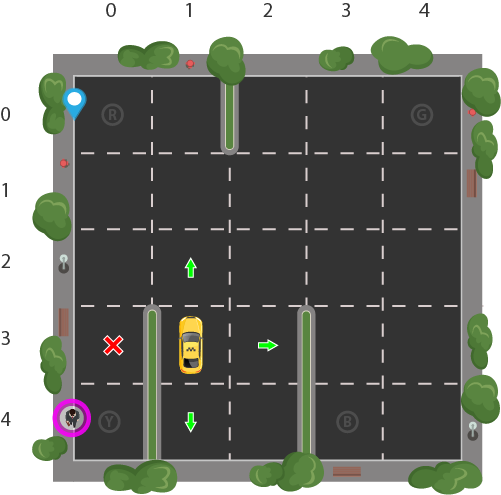

*image from [this link](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)*

This environment simulates a self-driving cab in a simplified way. The cab should pick up a passenger from a source location and drop off at a goal destination inside a $5\times5$ grid with internal walls at fixed positions. The passenger can be in four possible locations (R, G, Y, B) before getting into the cab, and the destination can be any of these four locations as well. States can be expressed via three locations: the moving cab ($5\times5$), the passenger ($4 + 1$), and the destination ($4$). So there is $5\times5\times5\times4=500$ distinct states. 

The cab can move in four main directions and pick up/drop off the passenger. So the action space contains six corresponding actions. Finally, for every movement, there is a $-1$ reward (to encourage more straightforward movement towards the passenger and destination). If the agent tries to pick up/drop off the passenger out of place, it will receive a $-10$ reward, and for appropriately dropping off the passenger, a $+20$ reward will be given.

You can run the following cells to see the specifications of the environment and the results of the completely random policy. The passenger and the destination are shown by blue and purple characters respectively.

In [31]:
# !pip install texttable
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
from texttable import Texttable

# You can use these methods later in the code.
def print_frames(frames, env, show_transition=True, wait_time=0):
    """
    This method renders an episode. 

    - frames: an array of per-timestep dictionaries with ('frame', 'state', 
      'reward', 'action') as keys;
      You can record the frame at every state using env.render(mode='ansi').
    - env: an instance of Taxi-v3 environment;
    - show_transition:‌ whether to print the transition table at every timestep;
    - wait_time: time step between consecutive frames;
    """
    action_mappings = ['South', 'North', 'East', 'West', 'Pickup', 'Dropoff']
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(f"Timestep: {i + 1}")

        print(frame['frame'])

        print(f"State: {frame['state']}")
        print(f"Action: {action_mappings[frame['action']]} ({frame['action']})")
        print(f"Reward: {frame['reward']}")
        
        if show_transition:
            rows = [['action', 'probability', 'next state', 'reward', 'done']]
            for k, v in env.P[frame['state']].items():
                probability, nextstate, reward, done = v[0]
                rows.append([k, probability, nextstate, reward, done])
            table = Texttable()
            table.add_rows(rows)

            print(f"\nTransitions at {frame['state']}:")
            print(table.draw())
        sleep(wait_time)

def plot_curves(curves, title, smooth=True, w_size=50):
    """
    This method plots series specified in `curves['series']`
    inside the same figure.

    - curves: a dictionary, dict(curves=a list of lists, labels=a list of strings);
    - title: figure's title;
    - smooth: whether to take a moving average over each series;
    - w_size: size of the moving average window;

    Notice: Series must have the same length.
    """
    series, labels = curves['series'], curves['labels']  
    N = len(series[0])
    assert all([len(s) == N for s in series])     
    x = list(range(N))
    for s, label in zip(series, labels):
        window = np.ones(w_size)/w_size
        s_smooth = np.convolve(s, window, mode='same')
        y = s_smooth[w_size:N-w_size] if smooth else s
        plt.plot(x[w_size:N-w_size], y, label=label)
    plt.legend()
    plt.title(title)
    plt.show()

In [32]:
# Let's instantiate the environment and see its properties.
env_id = "Taxi-v3"
env = gym.make(env_id)
spec = gym.spec(env_id)

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")

Action Space: Discrete(6)
Observation Space: Discrete(500)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 8



In [35]:
# A demo of the completely random policy
state = env.reset()
done = False
frames = []
while not done:
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
print_frames(frames, env, wait_time=0.1)

Timestep: 200
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

State: 361
Action: West (3)
Reward: -1

Transitions at 361:
+--------+-------------+------------+--------+------+
| action | probability | next state | reward | done |
+========+=============+============+========+======+
| 0      | 1           | 461        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 1      | 1           | 261        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 2      | 1           | 381        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 3      | 1           | 361        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 4      | 1           | 361        | -10    | 0    |
+--------+-------------+------------+--------+------+
| 5      | 1           | 361        | -10    | 0    |
+--------+-------------+------------+--------+------+


# Implementation

In [75]:
class TDRL():
    def __init__(self, env_id='Taxi-v3', epsilon=0.15, alpha=0.1, gamma=0.6, 
                 mode='q_learning', decay_rate=0.9999, decay_epsilon=True):
        
        assert env_id == 'Taxi-v3', 'Only Taxi-v3 environment is supported.'
        self.env = gym.make(env_id)
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        self.epsilon = 1
        self.fixed_eps = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.mode = mode # a string, 'SARSA' for SARSA and 'q_learning' for Q-learning
        self.decay_epsilon = decay_epsilon
        self.decay_rate = decay_rate

    def select_action(self, state, eval=False):
        ################ ToDo (5 points) ###############
        # Select the action based on state. Use        #
        # epsilon-greedy action selection during       #
        # training phase in the following cases:       #
        # 1) fixed epsilon (equal to self.fixed_eps)   #
        # 2) decaying epsilon (1 to self.fixed_eps)    #
        #    with the multiplicative rate specified in #
        #    self.decay_rate.                          #
        # `eval` indicates whether it is training time #
        # or not. Don't apply epsilon-greedy selection #
        # at test time.                                #
        ################################################
        best_action = np.argmax(self.Q[state, :])
        if eval:
            return best_action
        if self.decay_epsilon:
            eps = self.epsilon
        else:
            eps = self.fixed_eps
        random_number = np.random.uniform(0, 1)
        if random_number > eps:
            return best_action
        random_action = np.random.randint(0, self.Q.shape[1])
        if self.decay_epsilon:
            self.epsilon = max(self.epsilon * self.decay_rate, self.fixed_eps) 
        return random_action

    def update_Q(self, reward, state, next_state, action, next_action, done):
        ################ ToDo (5 points) ##################
        # Update Q-table according to the specified SARSA #
        # or Q-learning update rule.                      #
        ###################################################
        if (self.mode == 'q_learning') or (done):
            next_action = np.argmax(self.Q[next_state, :])
            self.Q[state, action] = (1 - self.alpha) * self.Q[state, action] + self.alpha * (reward + self.gamma * self.Q[next_state, next_action])
        elif self.mode == 'SARSA':
            self.Q[state, action] = (1 - self.alpha) * self.Q[state, action] + self.alpha * (reward + self.gamma * self.Q[next_state, next_action])
        
    def run_episodes(self, n_episodes):
        #################### ToDo (6 points) #####################
        # At every step of each episode, you should:             #
        # 1) choose proper action (eval=False)                   #
        # 2) execute that action in the environment.             #
        # 3) update Q-table accordingly.                         #
        # 4) record discounted total return of each episode.     #
        # 5) record number of times the agent gets a -10 reward  #
        #    during each episode (called penalty).               #
        # 6) plot total return and penalty across episodes       #
        ##########################################################
        
        DTRs = []
        num_penalties = []
        
        for episode in range(n_episodes):
            state = self.env.reset()
            
            discounted_total_return = 0
            step_number = 0
            penalties = 0
            done = False

            # Step 1
            action = self.select_action(state, eval=False)
            while not done:

                # Step 2
                next_state, reward, done, _ = self.env.step(action)

                # Step 3
                next_action = self.select_action(next_state, eval=False)
                self.update_Q(reward, state, next_state, action, next_action, done) 
                action = next_action
                state = next_state

                # Step 4
                discounted_total_return += (self.gamma ** step_number) * reward

                # Step 5
                if reward == -10:
                    penalties += 1

                step_number += 1
            
            DTRs.append(discounted_total_return)
            num_penalties.append(penalties)
            if (episode + 1) % 100 == 0:
                print('Episode {} finished'.format(episode + 1))

        # Step 6
        plt.style.use(['dark_background'])
        plt.rc('axes', facecolor='k')
        plt.rc('figure', facecolor='k')
        plt.rc('figure', figsize=(12, 5), dpi=100)
        fig, ax = plt.subplots(1, 2)
        xaxis = range(1, n_episodes + 1)
        ax[0].plot(xaxis, DTRs, c='b')
        ax[0].set_xlabel('Episode Number')
        ax[0].set_ylabel('Total Return')
        ax[1].plot(xaxis, num_penalties, c='r')
        ax[1].set_xlabel('Episode Number')
        ax[1].set_xlabel('Number of penalties')
        plt.show()

    def evaluate(self, n_episodes, print_res=True):
        ##################### ToDo (4 points) ####################
        # Similar to training time, run evaluation episodes and  #
        # report average total return, penalty, episode          #
        # length, and success rate across episodes. An episode   #
        # is considered successful if reward is 20 in the last   #
        # step.                                                  #
        # Also record frames for the episode with highest return #
        # and print it using `print_frames`.                     #
        ##########################################################
        
        DTRs = []
        num_penalties = []
        episode_lengths = []
        success = []
        best_return = float('-inf')
        best_episode_frames = None
        
        for episode in range(n_episodes):
            state = self.env.reset()
            
            discounted_total_return = 0
            step_number = 0
            penalties = 0
            done = False
            frames = []

            while not done:

                # Step 1
                action = self.select_action(state, eval=True)

                # Step 2
                next_state, reward, done, _ = self.env.step(action)

                # Step 4
                discounted_total_return += (self.gamma ** step_number) * reward

                # Step 5
                if reward == -10:
                    penalties += 1

                step_number += 1

                frames.append({
                    'frame': self.env.render(mode='ansi'),
                    'state': state,
                    'action': action,
                    'reward': reward
                    }
                )
                state = next_state


            
            DTRs.append(discounted_total_return)
            num_penalties.append(penalties)
            episode_lengths.append(step_number)
            if reward == 20:
                success.append(1)
            else:
                success.append(0)
            if discounted_total_return > best_return:
                best_return = discounted_total_return
                best_episode_frames = frames
            if (episode + 1) % 100 == 0:
                print('Episode {} finished'.format(episode + 1))


        print_frames(best_episode_frames, self.env, wait_time=0.1)
        print('Average total return: {}'.format(sum(DTRs) / len(DTRs)))
        print('Average number of penalties: {}'.format(sum(num_penalties) / len(num_penalties)))
        print('Average episode length: {}'.format(sum(episode_lengths) / len(episode_lengths)))
        print('Success rate: {}'.format(sum(success) / len(success)))

# Comparisons

In [76]:
n_episodes_train = 8000
n_episodes_test = 500
# You can change parameters of TDRL as you wish.

## Decaying epsilon

Episode 100 finished
Episode 200 finished
Episode 300 finished
Episode 400 finished
Episode 500 finished
Episode 600 finished
Episode 700 finished
Episode 800 finished
Episode 900 finished
Episode 1000 finished
Episode 1100 finished
Episode 1200 finished
Episode 1300 finished
Episode 1400 finished
Episode 1500 finished
Episode 1600 finished
Episode 1700 finished
Episode 1800 finished
Episode 1900 finished
Episode 2000 finished
Episode 2100 finished
Episode 2200 finished
Episode 2300 finished
Episode 2400 finished
Episode 2500 finished
Episode 2600 finished
Episode 2700 finished
Episode 2800 finished
Episode 2900 finished
Episode 3000 finished
Episode 3100 finished
Episode 3200 finished
Episode 3300 finished
Episode 3400 finished
Episode 3500 finished
Episode 3600 finished
Episode 3700 finished
Episode 3800 finished
Episode 3900 finished
Episode 4000 finished
Episode 4100 finished
Episode 4200 finished
Episode 4300 finished
Episode 4400 finished
Episode 4500 finished
Episode 4600 finish

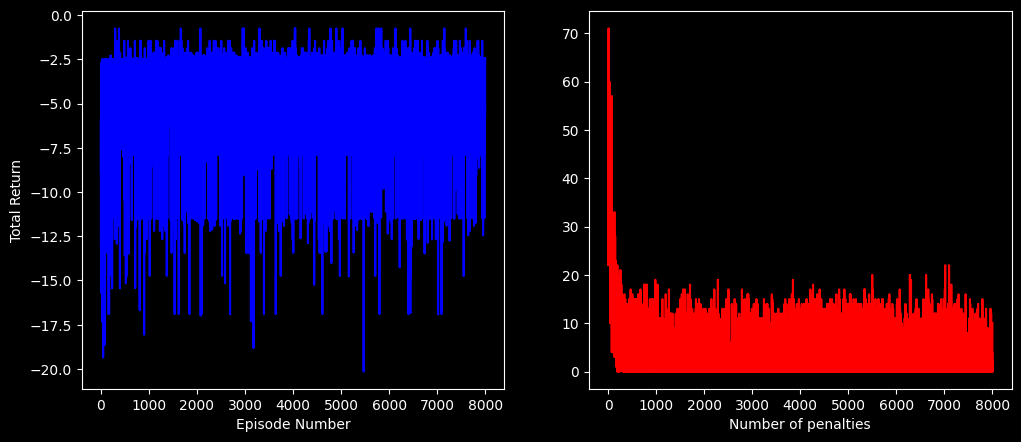

In [67]:
sarsa = TDRL(mode='SARSA')
sarsa_out = sarsa.run_episodes(n_episodes_train)

In [68]:
sarsa_eval = sarsa.evaluate(n_episodes_test)

Timestep: 6
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

State: 16
Action: Dropoff (5)
Reward: 20

Transitions at 16:
+--------+-------------+------------+--------+------+
| action | probability | next state | reward | done |
+========+=============+============+========+======+
| 0      | 1           | 116        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 1      | 1           | 16         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 2      | 1           | 36         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 3      | 1           | 16         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 4      | 1           | 16         | -10    | 0    |
+--------+-------------+------------+--------+------+
| 5      | 1           | 0          | 20     | 1    |
+--------+-------------+------------+--------+------+
Average total return

Episode 100 finished
Episode 200 finished
Episode 300 finished
Episode 400 finished
Episode 500 finished
Episode 600 finished
Episode 700 finished
Episode 800 finished
Episode 900 finished
Episode 1000 finished
Episode 1100 finished
Episode 1200 finished
Episode 1300 finished
Episode 1400 finished
Episode 1500 finished
Episode 1600 finished
Episode 1700 finished
Episode 1800 finished
Episode 1900 finished
Episode 2000 finished
Episode 2100 finished
Episode 2200 finished
Episode 2300 finished
Episode 2400 finished
Episode 2500 finished
Episode 2600 finished
Episode 2700 finished
Episode 2800 finished
Episode 2900 finished
Episode 3000 finished
Episode 3100 finished
Episode 3200 finished
Episode 3300 finished
Episode 3400 finished
Episode 3500 finished
Episode 3600 finished
Episode 3700 finished
Episode 3800 finished
Episode 3900 finished
Episode 4000 finished
Episode 4100 finished
Episode 4200 finished
Episode 4300 finished
Episode 4400 finished
Episode 4500 finished
Episode 4600 finish

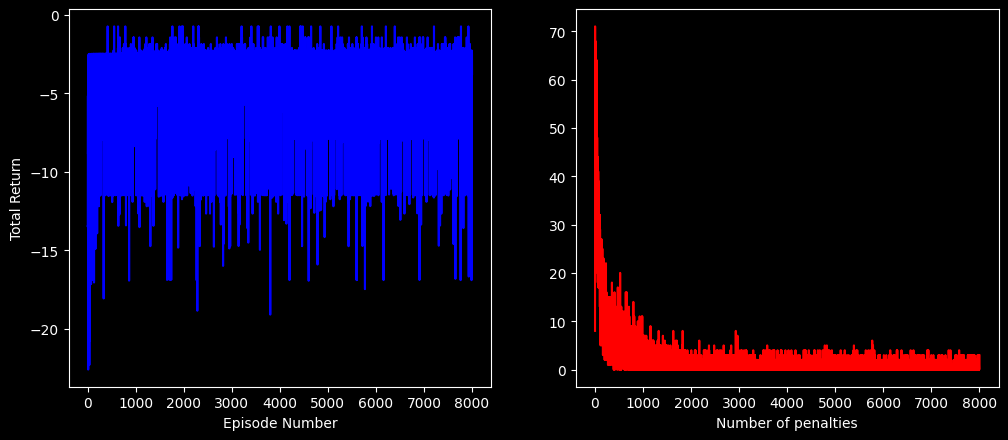

In [77]:
q_learning = TDRL(mode='q_learning')
q_learning_out = q_learning.run_episodes(n_episodes_train)

In [78]:
q_learning_eval = q_learning.evaluate(n_episodes_test)

Timestep: 6
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

State: 16
Action: Dropoff (5)
Reward: 20

Transitions at 16:
+--------+-------------+------------+--------+------+
| action | probability | next state | reward | done |
+========+=============+============+========+======+
| 0      | 1           | 116        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 1      | 1           | 16         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 2      | 1           | 36         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 3      | 1           | 16         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 4      | 1           | 16         | -10    | 0    |
+--------+-------------+------------+--------+------+
| 5      | 1           | 0          | 20     | 1    |
+--------+-------------+------------+--------+------+
Average total return

## Fixed epsilon

Episode 100 finished
Episode 200 finished
Episode 300 finished
Episode 400 finished
Episode 500 finished
Episode 600 finished
Episode 700 finished
Episode 800 finished
Episode 900 finished
Episode 1000 finished
Episode 1100 finished
Episode 1200 finished
Episode 1300 finished
Episode 1400 finished
Episode 1500 finished
Episode 1600 finished
Episode 1700 finished
Episode 1800 finished
Episode 1900 finished
Episode 2000 finished
Episode 2100 finished
Episode 2200 finished
Episode 2300 finished
Episode 2400 finished
Episode 2500 finished
Episode 2600 finished
Episode 2700 finished
Episode 2800 finished
Episode 2900 finished
Episode 3000 finished
Episode 3100 finished
Episode 3200 finished
Episode 3300 finished
Episode 3400 finished
Episode 3500 finished
Episode 3600 finished
Episode 3700 finished
Episode 3800 finished
Episode 3900 finished
Episode 4000 finished
Episode 4100 finished
Episode 4200 finished
Episode 4300 finished
Episode 4400 finished
Episode 4500 finished
Episode 4600 finish

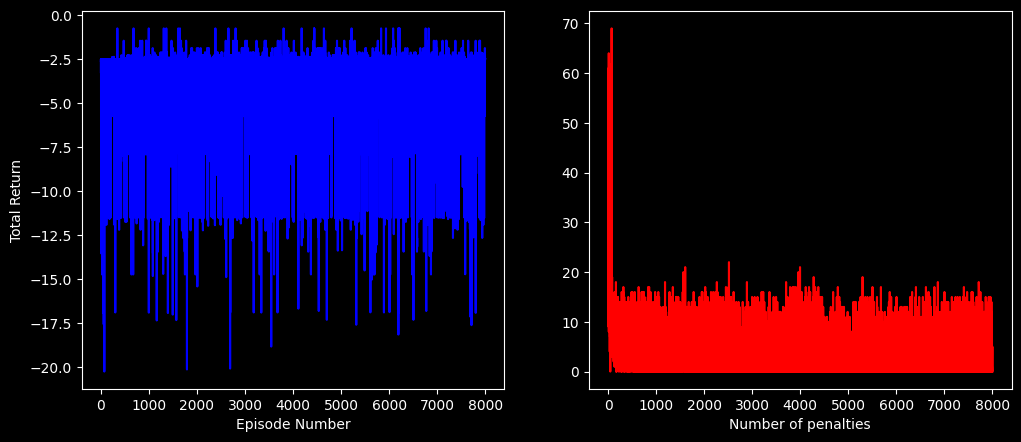

In [79]:
sarsa_fixed = TDRL(mode='SARSA', decay_epsilon=False)
sarsa_fixed_out = sarsa_fixed.run_episodes(n_episodes_train)

In [81]:
sarsa_fixed_eval = sarsa_fixed.evaluate(n_episodes_test)

Timestep: 6
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

State: 16
Action: Dropoff (5)
Reward: 20

Transitions at 16:
+--------+-------------+------------+--------+------+
| action | probability | next state | reward | done |
+========+=============+============+========+======+
| 0      | 1           | 116        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 1      | 1           | 16         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 2      | 1           | 36         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 3      | 1           | 16         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 4      | 1           | 16         | -10    | 0    |
+--------+-------------+------------+--------+------+
| 5      | 1           | 0          | 20     | 1    |
+--------+-------------+------------+--------+------+
Average total return

Episode 100 finished
Episode 200 finished
Episode 300 finished
Episode 400 finished
Episode 500 finished
Episode 600 finished
Episode 700 finished
Episode 800 finished
Episode 900 finished
Episode 1000 finished
Episode 1100 finished
Episode 1200 finished
Episode 1300 finished
Episode 1400 finished
Episode 1500 finished
Episode 1600 finished
Episode 1700 finished
Episode 1800 finished
Episode 1900 finished
Episode 2000 finished
Episode 2100 finished
Episode 2200 finished
Episode 2300 finished
Episode 2400 finished
Episode 2500 finished
Episode 2600 finished
Episode 2700 finished
Episode 2800 finished
Episode 2900 finished
Episode 3000 finished
Episode 3100 finished
Episode 3200 finished
Episode 3300 finished
Episode 3400 finished
Episode 3500 finished
Episode 3600 finished
Episode 3700 finished
Episode 3800 finished
Episode 3900 finished
Episode 4000 finished
Episode 4100 finished
Episode 4200 finished
Episode 4300 finished
Episode 4400 finished
Episode 4500 finished
Episode 4600 finish

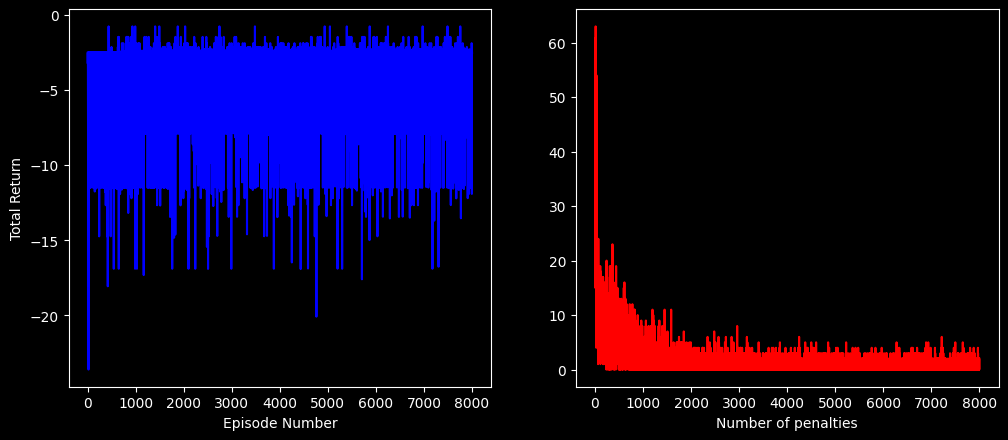

In [82]:
q_learning_fixed = TDRL(mode='q_learning', decay_epsilon=False)
q_learning_fixed_out = q_learning_fixed.run_episodes(n_episodes_train)

In [83]:
q_learning_fixed_eval = q_learning.evaluate(n_episodes_test)

Timestep: 6
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

State: 418
Action: Dropoff (5)
Reward: 20

Transitions at 418:
+--------+-------------+------------+--------+------+
| action | probability | next state | reward | done |
+========+=============+============+========+======+
| 0      | 1           | 418        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 1      | 1           | 318        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 2      | 1           | 418        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 3      | 1           | 418        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 4      | 1           | 418        | -10    | 0    |
+--------+-------------+------------+--------+------+
| 5      | 1           | 410        | 20     | 1    |
+--------+-------------+------------+--------+------+
Average total retu

**Question (5 points):**

Compare these methods and explain your results bsed on average return, penalty, episode length and success rate. It would be nice to plot learning curves using `plot_curves` method.

**Answer:** ...


In [85]:
rows = [['method', 'Average total return', 'Average number of penalties', 'Average episode length', 'Rate of success']]

rows.append(['SARSA (decaying epsilon)', '-2.410', '0.0', '86.494', '0.608'])
rows.append(['Q-learning (decaying epsilon)', '-2.377', '0.0', '22.522', '0.948'])
rows.append(['SARSA (fixed epsilon)', '-2.441', '0.0', '130.586', '0.37'])
rows.append(['Q-learning (fixed epsilon)', '2.392', '0.0', '25.66', '0.932'])

table = Texttable()
table.add_rows(rows)
print(table.draw())

+---------------+---------------+---------------+---------------+--------------+
|    method     | Average total |    Average    |    Average    |   Rate of    |
|               |    return     |   number of   |    episode    |   success    |
|               |               |   penalties   |    length     |              |
+===============+===============+===============+===============+==============+
| SARSA         | -2.410        | 0             | 86.494        | 0.608        |
| (decaying     |               |               |               |              |
| epsilon)      |               |               |               |              |
+---------------+---------------+---------------+---------------+--------------+
| Q-learning    | -2.377        | 0             | 22.522        | 0.948        |
| (decaying     |               |               |               |              |
| epsilon)      |               |               |               |              |
+---------------+-----------

# Analysis:
As we can see rate of success is noticably higher in q-learning rather than SARSA which means using q-learning we learn better policies and most of the time achieve the goal which is picking up client from the right location and droping them off at destination. As a result the episode duration for q-learning is also a lot smaller which means that the agent doesn't waste time wandering around and instead goes directly from source to destination. And finally higher average return for q-learning proves that this algorithm was better.

For both algorithms using decaying epsilon improves the performance. This is because decaying epsilon has a nice meaning which is to explore more at the beginning and by the time we reach the end exploit what is learnt because most of the environment has already been explored.

Overall in this exercise "Q-learning with decaying epsilon" achieved the best results.